## import

In [39]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Hyperparameter 정의

`BATCH_SIZE`와 `EPOCHS`를 정의합니다.

In [2]:
BATCH_SIZE = 64
EPOCHS = 20

In [3]:
dataset_name = 'cats_vs_dogs'
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split=('train[:80%]', 'train[-20%:]'), with_info=True)

In [4]:
len(list(train_dataset)), len(list(validation_dataset))

(18610, 4652)

## 이미지에 대한 Normalize를 진행합니다.

In [5]:
def normalize(images):
    # 0~1 사이의 값으로 Normalize 합니다.
    img, lbl = tf.cast(images['image'], tf.float32) / 255.0, images['label']
    # 300 X 300 사이즈로 resize 합니다.
    img = tf.image.resize(img, size=(300, 300))
    return img, lbl

`normalize`를 수행합니다.

`Training Set`와 `Validation Set`을 만들고 **BATCH_SIZE**에 따라 mini batch를 만듭니다.

In [6]:
train_data = train_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)
valid_data = validation_dataset.map(normalize).batch(BATCH_SIZE).repeat().prefetch(1)

`steps_per_epoch`과 `validation_steps`를 정의하여 train 합니다.

In [7]:
steps_per_epoch= int(len(list(train_dataset)) * 0.8) // BATCH_SIZE + 1
validation_steps= int(len(list(validation_dataset)) * 0.2) // BATCH_SIZE + 1

## Convolution Neural Network

In [8]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Flatten(), 
    Dense(512, activation='relu'), 
    Dense(32, activation='relu'), 
    Dense(1, 'sigmoid')
])

In [9]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
cnn_history = model_cnn.fit(train_data, 
                            validation_data=(valid_data),
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            epochs=20, 
                           )

Train for 233 steps, validate for 15 steps
Epoch 1/20
233/233 [==============================] - 17s 72ms/step - loss: 0.6577 - accuracy: 0.5878 - val_loss: 0.6195 - val_accuracy: 0.6552
Epoch 2/20
233/233 [==============================] - 13s 56ms/step - loss: 0.5613 - accuracy: 0.7031 - val_loss: 0.5112 - val_accuracy: 0.7594
Epoch 3/20
233/233 [==============================] - 11s 45ms/step - loss: 0.4517 - accuracy: 0.7891 - val_loss: 0.4102 - val_accuracy: 0.8229
Epoch 4/20
233/233 [==============================] - 10s 45ms/step - loss: 0.3710 - accuracy: 0.8328 - val_loss: 0.4086 - val_accuracy: 0.8156
Epoch 5/20
233/233 [==============================] - 11s 45ms/step - loss: 0.3044 - accuracy: 0.8677 - val_loss: 0.4010 - val_accuracy: 0.8208
Epoch 6/20
233/233 [==============================] - 11s 45ms/step - loss: 0.2623 - accuracy: 0.8877 - val_loss: 0.3326 - val_accuracy: 0.8687
Epoch 7/20
233/233 [==============================] - 11s 45ms/step - loss: 0.2223 - accuracy

## Transfer Learning (VGG 16)

**VGG-16**은 ImageNet 데이터베이스의 1백만 개가 넘는 영상에 대해 훈련된 컨벌루션 신경망입니다. 이 네트워크에는 16개의 계층이 있으며, 영상을 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 그 결과 이 네트워크는 다양한 영상을 대표하는 다양한 특징을 학습했습니다. 

**VGG-16모델**을 활용하여 Transfer Learning 을 진행합니다.

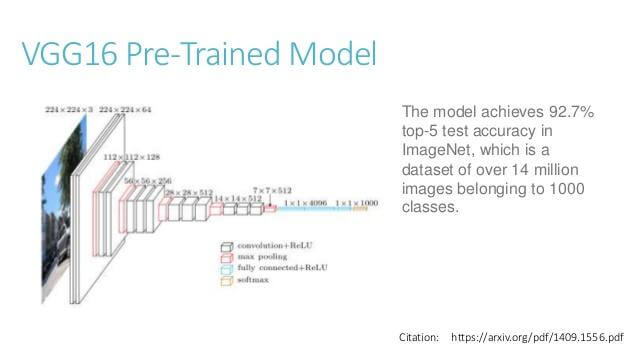

In [38]:
Image('https://s3.ap-south-1.amazonaws.com/techleer/309.jpg')

In [11]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

In [12]:
transfer_model.trainable=False

In [13]:
model_tr = Sequential([
    transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(1, 'sigmoid')
])

In [14]:
model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
transfer_history = model_tr.fit(train_data, 
                             validation_data=(valid_data),
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps,
                             epochs=20, 
                            )

Train for 233 steps, validate for 15 steps
Epoch 1/20
233/233 [==============================] - 41s 178ms/step - loss: 0.3201 - accuracy: 0.8859 - val_loss: 0.1462 - val_accuracy: 0.9427
Epoch 2/20
233/233 [==============================] - 40s 173ms/step - loss: 0.1331 - accuracy: 0.9484 - val_loss: 0.1656 - val_accuracy: 0.9375
Epoch 3/20
233/233 [==============================] - 39s 166ms/step - loss: 0.1059 - accuracy: 0.9599 - val_loss: 0.1468 - val_accuracy: 0.9375
Epoch 4/20
233/233 [==============================] - 39s 167ms/step - loss: 0.1154 - accuracy: 0.9526 - val_loss: 0.1532 - val_accuracy: 0.9417
Epoch 5/20
233/233 [==============================] - 39s 167ms/step - loss: 0.1043 - accuracy: 0.9591 - val_loss: 0.2137 - val_accuracy: 0.9187
Epoch 6/20
233/233 [==============================] - 39s 167ms/step - loss: 0.1125 - accuracy: 0.9555 - val_loss: 0.1356 - val_accuracy: 0.9490
Epoch 7/20
233/233 [==============================] - 39s 166ms/step - loss: 0.0930 - a

## 성능 Visualization

**Losses** 와 **Accuracy**를 보면, Transfer Learning 모델이 훨씬 초기 수렴이 빠를 뿐더러, 최종 성능도 accuracy 기준 **약 10%** 가량 우수하다는 것을 확인할 수 있습니다.

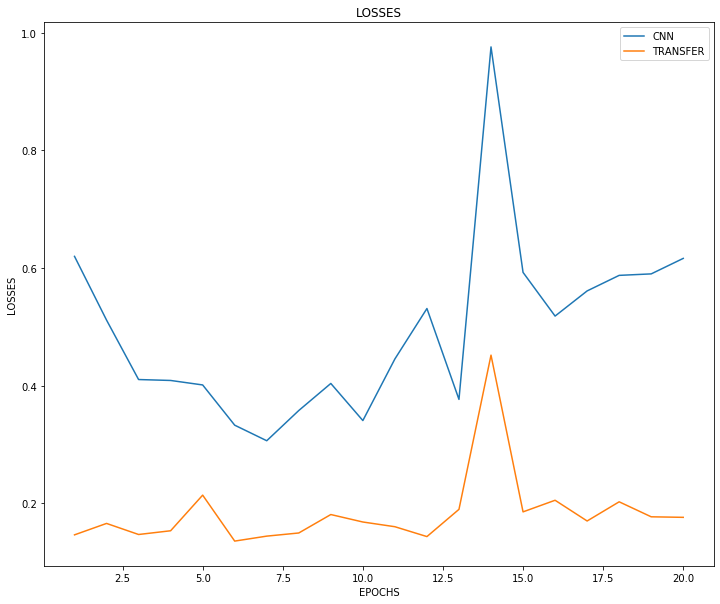

In [35]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_loss'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_loss'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()

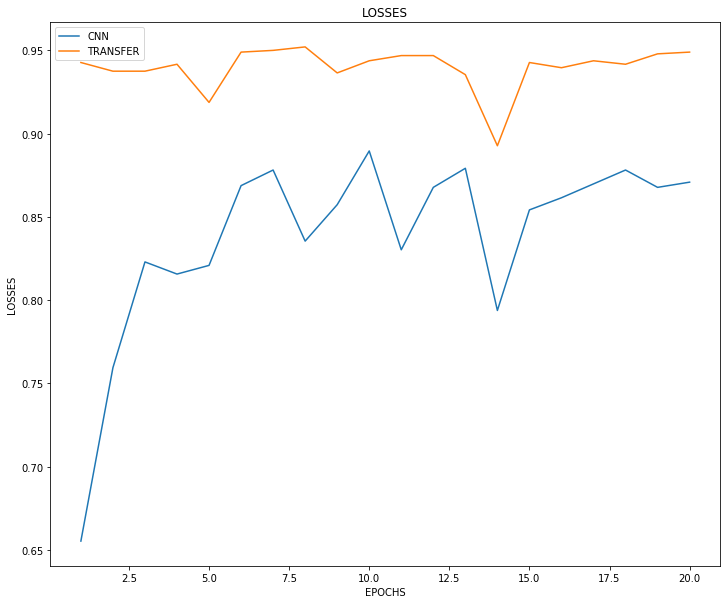

In [36]:
plt.figure(figsize=(12, 10))
plt.plot(np.arange(1, EPOCHS+1), cnn_history.history['val_accuracy'], label='CNN')
plt.plot(np.arange(1, EPOCHS+1), transfer_history.history['val_accuracy'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()